In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
!nvidia-smi

Tue Nov 12 21:39:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 480.2 kB/s eta 0:00:00


In [ ]:
!pip install datasets

In [ ]:
!pip install datasets

In [ ]:
!pip install evaluate

In [ ]:
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
import evaluate  # Use this to replace load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:

def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [ ]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
]
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
!pip install py7zr

In [ ]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][1]["summary"])

README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


In [ ]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][1]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


In [ ]:
dataset_samsum['test'][0]['dialogue']

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )

print(pipe_out)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [ ]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [ ]:
!pip install rouge_score

In [ ]:
rouge_metric = evaluate.load('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8)

100%|██████████| 103/103 [18:44<00:00, 10.92s/it]


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

# Directly access the ROUGE scores without 'mid.fmeasure'
rouge_dict = {rn: score[rn] for rn in rouge_names}

# Display the results in a DataFrame
pd.DataFrame(rouge_dict, index=['pegasus'])


NameError: name 'score' is not defined

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


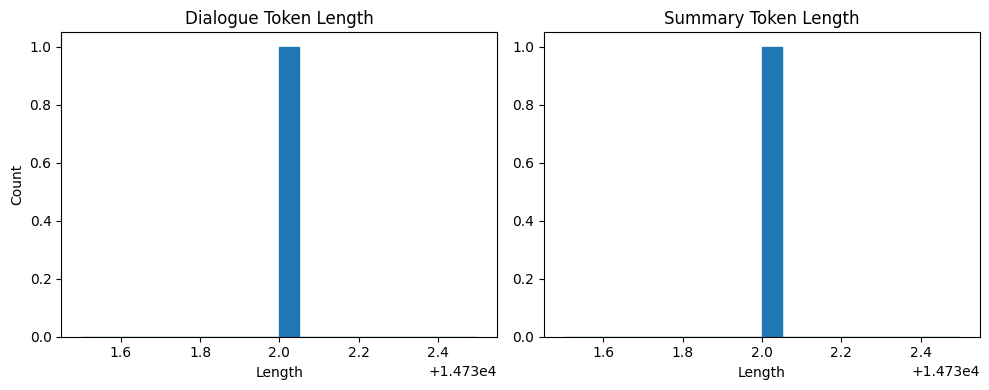

In [ ]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM

[Errno 2] No such file or directory: '/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM'
/content


In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:

trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

<ipython-input-29-791f871c2444>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_pegasus, args=trainer_args,


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
500,1.659700,1.484200


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=920, training_loss=1.825385618209839, metrics={'train_runtime': 2956.8663, 'train_samples_per_second': 4.982, 'train_steps_per_second': 0.311, 'total_flos': 5528248038285312.0, 'train_loss': 1.825385618209839, 'epoch': 0.9991854466467553})

In [ ]:
from google.colab import drive
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

# Mount Google Drive
drive.mount('/content/drive')

# Load the pre-trained model and tokenizer
model_name = "google/pegasus-xsum"
model = PegasusForConditionalGeneration.from_pretrained(model_name)
tokenizer = PegasusTokenizer.from_pretrained(model_name)

# Define the path on Google Drive where the model will be saved
save_directory = '/content/drive/My Drive/pegasus-xsum'

# Save the model and tokenizer to Google Drive
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer have been saved to {save_directory}.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'num_beams': 8, 'length_penalty': 0.6}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Model and tokenizer have been saved to /content/drive/My Drive/pegasus-xsum.


In [ ]:
# Define the path on Google Drive where the model will be saved
save_directory = '/content/drive/MyDrive/pegasus-xsum'

# Save the model and tokenizer to Google Drive
model.save_pretrained(save_directory)

NameError: name 'model' is not defined

In [ ]:
tokenizer.save_pretrained(save_directory)

In [ ]:

score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 410/410 [13:35<00:00,  1.99s/it]


AttributeError: 'numpy.float64' object has no attribute 'mid'

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the saved model
saved_model_directory = '/content/drive/My Drive/pegasus-xsum'
model = PegasusForConditionalGeneration.from_pretrained(saved_model_directory)
tokenizer = PegasusTokenizer.from_pretrained(saved_model_directory)

# Example input text
input_text = """
1800 fraudulent bank accounts opened in all over the country, fined Rs. 2 crores, the indictment of the scammer.
"""

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)

# Generate summary using the model
summary_ids = model.generate(inputs["input_ids"], max_length=1000, num_beams=4, early_stopping=True)

# Decode the generated summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print the summary
print("Generated Summary:")
print(summary)


Mounted at /content/drive
Generated Summary:
Fraudsters in India have been caught after an investigation by the Reserve Bank of India.


In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the saved model and tokenizer from Google Drive
saved_model_directory = '/content/drive/My Drive/pegasus-xsum'
model = PegasusForConditionalGeneration.from_pretrained(saved_model_directory)
tokenizer = PegasusTokenizer.from_pretrained(saved_model_directory)

# Example input text
input_text = """
Washington:
The US had never approved Kyiv to use long-range missiles in Russia, until now.
The Biden administration has made a significant policy change, allowing Ukraine to use US-made ATACMS missiles to strike targets inside Russia for the first time.
This decision comes just two months before President Joe Biden hands over power to Donald Trump, who has expressed scepticism about US military aid to Ukraine.
Ukraine has been using ATACMS missiles against Russian targets in occupied Ukrainian territory for over a year, but the US had previously prohibited their use inside Russia due to concerns about escalating the conflict.
"It would substantially change the very essence, the nature of the conflict. This will mean that Nato countries, the USA and European states, are fighting with Russia", Putin had said in September.
However, the recent deployment of North Korean troops to support Russia in the Kursk border region has prompted the policy change.
"""

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt", max_length=2048, truncation=True)

# Generate summary using the model
summary_ids = model.generate(inputs["input_ids"], max_length=1000, num_beams=4, early_stopping=True)

# Decode the generated summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print the summary
print("Generated Summary:")
print(summary)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generated Summary:
The US has approved Ukraine's use of long-range missiles inside Russia for the first time.


In [ ]:
dataset_samsum = load_dataset("samsum")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

In [ ]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
!pip install transformers
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast, PegasusForConditionalGeneration, PegasusTokenizer

# Load mBART model and tokenizer for translation
mbart_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
mbart_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
mbart_tokenizer.src_lang = "hi_IN"

# Load PEGASUS model and tokenizer for summarization
pegasus_model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
pegasus_tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")

def translate(text):
    # Tokenize and generate translation using mBART
    inputs = mbart_tokenizer(text, return_tensors="pt")
    translated_tokens = mbart_model.generate(**inputs, forced_bos_token_id=mbart_tokenizer.lang_code_to_id["en_XX"])
    translation = mbart_tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translation

def summarize(text):
    # Tokenize and generate summary using PEGASUS
    inputs = pegasus_tokenizer(text, truncation=True, padding="longest", return_tensors="pt")
    summary_tokens = pegasus_model.generate(**inputs)
    summary = pegasus_tokenizer.decode(summary_tokens[0], skip_special_tokens=True)
    return summary


# Example usage
news_article = "हाल ही में एक व्यक्ति ने Reddit पर जर्मनी के पिस्सू बाजार में मिले एक अज्ञात देवनागरी टेक्स्ट की पहचान करने के लिए ऑनलाइन मदद मांगी. Reddit पर AcceptableTea8746 नाम से जाने जाने वाले यूजर ने टेक्स्ट से भरे दो पीले पन्नों की तस्वीरें शेयर की हैं, जो संस्कृत में लिखी नजर आ रही हैं. उन्होंने यूजर्स से इन पन्नों की पहचान करने और इस पर क्या लिखा है ये बताने में मदद मांगी. पोस्ट को कैप्शन देते हुए रेडिट यूजर ने लिखा, जर्मनी के हैम्बर्ग में पिस्सू बाजार में यह मिला. क्या आप मुझे बता सकते हैं कि यह क्या है? व्यक्ति ने सबरेडिट r/india पर अपनी पोस्ट में लिखा.."
translated_text = translate(news_article)
summary_text = summarize(translated_text)

print("Translated Text:", translated_text)
print("Summary Text:", summary_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

Translated Text: Recently, a person on Reddit asked for online help to identify an unknown Devanagari text found in the pizza market in Germany. A user known as AcceptableTea8746 on Reddit has shared two yellow pages filled with text, which appear to be written in Sanskrit. He asked for help to identify these pages and tell the users what was written on it. In capturing the post, the Reddit user wrote, this was found in the pizza market in Hamburg, Germany. Can you tell me what this is? The person wrote in his post on subredit r / India..
Summary Text: A Devanagari text found in a pizza market in Germany has gone viral online.


In [ ]:
# Example usage
news_article = "1800 फर्जी बैंक खाते खोल देशभर में बेचे, वसूली 2 करोड़ रुपये की रकम, फर्जीवाड़े की इनसाइड स्टोरी"
translated_text = translate(news_article)
summary_text = summarize(translated_text)

print("Translated Text:", translated_text)
print("Summary Text:", summary_text)

Translated Text: 1800 Farm Bank Accounts Opened, sold across the country, recovered Rs. 2 crore, Inside Story of Farmers
Summary Text: The Central Bureau of Investigation (CBI) has arrested three people in connection with the sale of fake bank accounts in Madhya Pradesh.
